## **1. Descripción General**

El sistema de Club de Intercambio de Habilidades es una plataforma diseñada para facilitar el intercambio de conocimientos entre miembros, donde cada participante puede actuar tanto como maestro (enseñando habilidades que domina) como aprendiz (adquiriendo nuevos conocimientos).



## **2. Modelo de Datos**




### **2.1 Entidades Principales**

**Miembro**

Descripción: Participantes del sistema que pueden enseñar y aprender habilidades

Atributos:
- `id_miembro (PK):` Identificador único autoincremental
- `nombre:` Nombre completo (50 caracteres máx.)
- `email:` Dirección única para contacto
- `telefono:` Número de contacto (15 caracteres máx.)

**Habilidad**

Descripción: Conocimientos que pueden ser enseñados/aprendidos

Atributos:

- `id_habilidad (PK)`: Identificador único autoincremental
- `nombre:` Nombre de la habilidad (60 caracteres máx.)
- `categoria`: Área de conocimiento (40 caracteres máx.)

**Sesión**

Descripción: Encuentro programado para intercambio de conocimientos

Atributos:

- `id_sesion (PK):` Identificador único autoincremental
- `fecha:` Fecha y hora de realización
- `id_habilidad (FK):` Habilidad que se enseña
- `id_maestro (FK):` Miembro que enseña
- `id_aprendiz (FK):` Miembro que aprende

**Valoración**

Descripción: Retroalimentación sobre una sesión realizada

Atributos:
- `id_valoracion (PK):` Identificador único autoincremental
- `comentario:` Observaciones (200 caracteres máx.)
- `puntuacion:` Calificación (1-5)
- `id_sesion (FK):` Sesión evaluada
- `id_evaluador (FK):` Miembro que realiza la valoración


### **2.2 Modelo Entidad Relación (MER):**
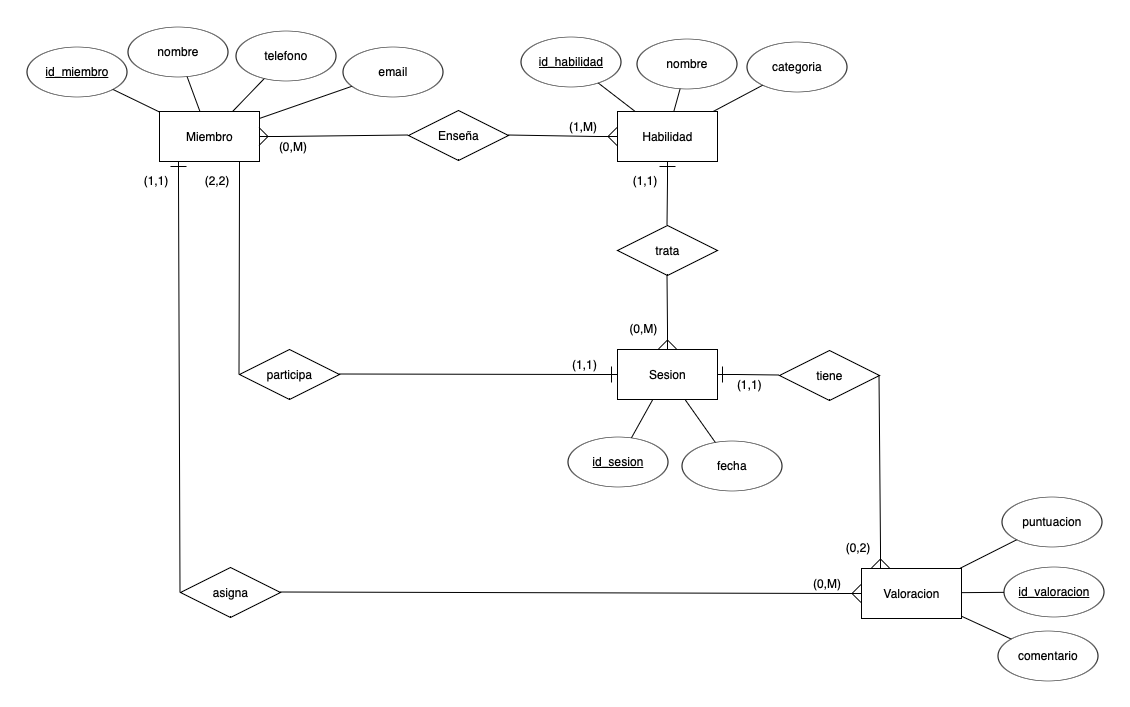

### **2.3 Modelo Relacional:**
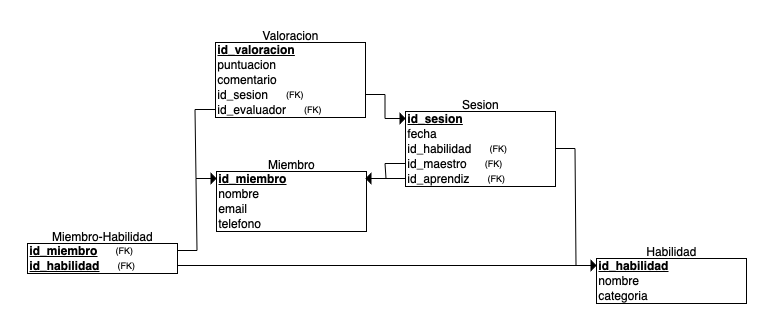

## **3. Reglas de Negocio**





### **3.1 Gestión de Miembros**

Cada miembro debe tener un email único en el sistema
Los miembros pueden registrarse sin habilidades iniciales
Un miembro puede ser maestro en unas sesiones y aprendiz en otras


###**3.2 Sesiones de Intercambio**

Requisitos para crear una sesión:

- El maestro debe tener la habilidad registrada en su perfil

- Maestro y aprendiz deben ser personas diferentes

- La fecha debe ser futura al momento de creación

- Estados posibles:

  `Programada` (por defecto)

  `Completada` (después de realizarse)

  `Cancelada` (si no se realiza)

###**3.3 Sistema de Valoraciones**

- Solo participantes de la sesión (maestro o aprendiz) pueden valorar

- La puntuación debe estar entre 1 (mínimo) y 5 (máximo)

- Cada sesión puede tener:

  Valoración del aprendiz hacia el maestro
  
  Valoración del maestro hacia el aprendiz


###**3.4 Habilidades**

- Cada habilidad pertenece a una categoría específica

- Las habilidades pueden ser añadidas por administradores del sistema

- No se permiten habilidades duplicadas (mismo nombre)

##  **4.Validación de datos:**



`CHECK (id_maestro != id_aprendiz):` Evita auto-sesiones

`CHECK (puntuacion BETWEEN 1 AND 5)`: Rango válido de valoraciones

`UNIQUE (email):` Garantiza cuentas únicas





## **5. Implementación de la Base de Datos:**

Se importan las librerias y se crea la conexión a la base de datos:

In [ ]:
import sqlite3
import pandas as pd
# Conectar a la base de datos (se crea automáticamente si no existe)
conn = sqlite3.connect('club_habilidades.db')
cursor = conn.cursor()

Script para la creación de las tablas:

In [1]:
%%writefile club_intercambio_create_tables.sql

PRAGMA foreign_keys=ON;

CREATE TABLE Miembro (
  id_miembro INTEGER PRIMARY KEY AUTOINCREMENT,
  nombre VARCHAR(50) NOT NULL,
  email VARCHAR(50) NOT NULL UNIQUE,
  telefono VARCHAR(15) NOT NULL
);

CREATE TABLE Habilidad (
  id_habilidad INTEGER PRIMARY KEY AUTOINCREMENT,
  nombre VARCHAR(60) NOT NULL,
  categoria VARCHAR(40) NOT NULL
);

CREATE TABLE Sesion (
  id_sesion INTEGER PRIMARY KEY AUTOINCREMENT,
  fecha DATETIME NOT NULL,
  id_habilidad INTEGER NOT NULL,
  id_maestro INTEGER NOT NULL,
  id_aprendiz INTEGER NOT NULL,
  FOREIGN KEY (id_habilidad) REFERENCES Habilidad(id_habilidad),
  FOREIGN KEY (id_maestro) REFERENCES Miembro(id_miembro),
  FOREIGN KEY (id_aprendiz) REFERENCES Miembro(id_miembro),
  CHECK (id_maestro != id_aprendiz)
);

CREATE TABLE Valoracion (
  id_valoracion INTEGER PRIMARY KEY AUTOINCREMENT,
  comentario VARCHAR(200) NOT NULL,
  puntuacion INTEGER NOT NULL CHECK (puntuacion BETWEEN 1 AND 5),
  id_sesion INTEGER NOT NULL,
  id_evaluador INTEGER NOT NULL,
  FOREIGN KEY (id_sesion) REFERENCES Sesion(id_sesion),
  FOREIGN KEY (id_evaluador) REFERENCES Miembro(id_miembro)
);

CREATE TABLE Miembro_Habilidad (
  id_miembro INTEGER NOT NULL,
  id_habilidad INTEGER NOT NULL,
  PRIMARY KEY (id_miembro, id_habilidad),
  FOREIGN KEY (id_miembro) REFERENCES Miembro(id_miembro),
  FOREIGN KEY (id_habilidad) REFERENCES Habilidad(id_habilidad)
);

Writing club_intercambio_create_tables.sql


In [ ]:
#Ejecutamos el script que contiene la creación de tablas
sqlScript = open("club_intercambio_create_tables.sql").read()
cursor.executescript(sqlScript)

In [ ]:
#Hacemos ua consulta al catálogo de la base de datos.
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';",conn)

,name
0,Miembro
1,sqlite_sequence
2,Habilidad
3,Sesion
4,Valoracion
5,Miembro_Habilidad


In [ ]:
# Revisamos una tabla para ver que se haya creado correctamente
pd.read_sql("PRAGMA table_info(Miembro);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,id_miembro,INTEGER,0,None,1
1,1,nombre,VARCHAR(50),1,None,0
2,2,email,VARCHAR(50),1,None,0
3,3,telefono,VARCHAR(15),1,None,0


Script para poblar las tablas con datos

In [2]:
%%writefile club_intercambio_populate_data.sql

-- Iniciar transacción para asegurar integridad
BEGIN TRANSACTION;

-- Insertar 10 miembros
INSERT INTO Miembro (nombre, email, telefono) VALUES
('Ana López', 'ana.lopez@email.com', '+525512345678'),
('Carlos Ruiz', 'carlos.ruiz@email.com', '+525598765432'),
('María García', 'maria.garcia@email.com', '+525555555555'),
('Pedro Martínez', 'pedro.martinez@email.com', '+525511112222'),
('Luisa Fernández', 'luisa.fernandez@email.com', '+525533334444'),
('Jorge Sánchez', 'jorge.sanchez@email.com', '+525577776666'),
('Sofía Ramírez', 'sofia.ramirez@email.com', '+525588889999'),
('Miguel Torres', 'miguel.torres@email.com', '+525500001111'),
('Elena Castro', 'elena.castro@email.com', '+525522223333'),
('David Vargas', 'david.vargas@email.com', '+525544445555');

-- Insertar habilidades
INSERT INTO Habilidad (nombre, categoria) VALUES
('Python', 'Programación'),
('Fotografía Digital', 'Arte'),
('Cocina Italiana', 'Gastronomía'),
('Guitarra Acústica', 'Música'),
('Jardinería Orgánica', 'Hogar'),
('Inglés Avanzado', 'Idiomas'),
('Diseño Gráfico', 'Arte Digital'),
('Yoga', 'Bienestar'),
('Marketing Digital', 'Negocios'),
('Carpintería Básica', 'Manualidades');

-- Asignar habilidades a miembros
INSERT INTO Miembro_Habilidad (id_miembro, id_habilidad) VALUES
(1, 1), (1, 3),
(2, 2), (2, 6),
(3, 4), (3, 8),
(4, 5), (4, 10),
(5, 7), (5, 9),
(6, 1), (6, 6),
(7, 3), (7, 5),
(8, 2), (8, 4),
(9, 8), (9, 9),
(10, 7), (10, 10);

-- Crear sesiones de intercambio
INSERT INTO Sesion (fecha, id_habilidad, id_maestro, id_aprendiz) VALUES
('2023-05-10 14:00:00', 1, 1, 2),
('2023-05-11 16:00:00', 2, 2, 3),
('2023-05-12 10:00:00', 3, 7, 1),
('2023-05-13 11:00:00', 4, 3, 4),
('2023-05-14 15:00:00', 5, 4, 5),
('2023-05-15 17:00:00', 6, 2, 6),
('2023-05-16 09:00:00', 7, 5, 7),
('2023-05-17 18:00:00', 8, 9, 8),
('2023-05-18 19:00:00', 9, 5, 9),
('2023-05-19 20:00:00', 10, 10, 4);

-- Agregar valoraciones a las sesiones
INSERT INTO Valoracion (comentario, puntuacion, id_sesion, id_evaluador) VALUES
('Excelente explicación, muy paciente', 5, 1, 2),
('Buen contenido pero algo rápido', 4, 1, 1),
('Dominio impresionante del tema', 5, 2, 3),
('Clara y organizada', 5, 3, 1),
('Me costó seguir el ritmo', 3, 4, 4),
('Aprendí mucho, muy práctico', 5, 5, 5),
('Explicaciones muy técnicas', 4, 6, 6),
('Creativa y con buenos ejemplos', 5, 7, 7),
('Ambiente muy relajante', 5, 8, 8),
('Podría mejorar la organización', 3, 9, 9),
('Preciso y con buenos tips', 4, 10, 4);


COMMIT;

Writing club_intercambio_populate_data.sql


In [ ]:
# Ejecutamos el script que contiene la creación/modificación de tablas
sqlScript_datos = open("club_intercambio_populate_data.sql").read()
cursor.executescript(sqlScript_datos)

In [ ]:
# Revisamos una tabla para ver que se hayan agregados los datos correctamente
pd.read_sql("SELECT * FROM MIEMBRO", conn)

,id_miembro,nombre,email,telefono
0,1,Ana López,ana.lopez@email.com,+525512345678
1,2,Carlos Ruiz,carlos.ruiz@email.com,+525598765432
2,3,María García,maria.garcia@email.com,+525555555555
3,4,Pedro Martínez,pedro.martinez@email.com,+525511112222
4,5,Luisa Fernández,luisa.fernandez@email.com,+525533334444
5,6,Jorge Sánchez,jorge.sanchez@email.com,+525577776666
6,7,Sofía Ramírez,sofia.ramirez@email.com,+525588889999
7,8,Miguel Torres,miguel.torres@email.com,+525500001111
8,9,Elena Castro,elena.castro@email.com,+525522223333
9,10,David Vargas,david.vargas@email.com,+525544445555


## **6. Consultas SQL y Análisis de Negocio**

In [ ]:
# Top 5 habilidades más enseñadas
query1 = """
          SELECT h.nombre, COUNT(*) AS total_sesiones
          FROM Habilidad h
          JOIN Sesion s ON h.id_habilidad = s.id_habilidad
          GROUP BY h.id_habilidad
          ORDER BY total_sesiones DESC
          LIMIT 5 """
pd.read_sql(query1, conn)

,nombre,total_sesiones
0,Carpintería Básica,1
1,Marketing Digital,1
2,Yoga,1
3,Diseño Gráfico,1
4,Inglés Avanzado,1


In [ ]:
# Miembros más activos (como maestros o aprendices)
query2 = """
          SELECT m.nombre,
                COUNT(DISTINCT CASE WHEN s.id_maestro = m.id_miembro THEN s.id_sesion END) AS sesiones_maestro,
                COUNT(DISTINCT CASE WHEN s.id_aprendiz = m.id_miembro THEN s.id_sesion END) AS sesiones_aprendiz
          FROM Miembro m
          LEFT JOIN Sesion s ON m.id_miembro IN (s.id_maestro, s.id_aprendiz)
          GROUP BY m.id_miembro
          ORDER BY (sesiones_maestro + sesiones_aprendiz) DESC"""
pd.read_sql(query2, conn)

,nombre,sesiones_maestro,sesiones_aprendiz
0,Carlos Ruiz,2,1
1,Pedro Martínez,1,2
2,Luisa Fernández,2,1
3,Ana López,1,1
4,María García,1,1
5,Sofía Ramírez,1,1
6,Elena Castro,1,1
7,Jorge Sánchez,0,1
8,Miguel Torres,0,1
9,David Vargas,1,0


In [ ]:
# Miembros con habilidades que nunca han enseñado
query3 = """
          SELECT m.id_miembro, m.nombre,
                (SELECT GROUP_CONCAT(h.nombre, ', ')
                  FROM Miembro_Habilidad mh
                  JOIN Habilidad h ON mh.id_habilidad = h.id_habilidad
                  WHERE mh.id_miembro = m.id_miembro) AS habilidades
          FROM Miembro m
          WHERE
              EXISTS (
                  SELECT 1 FROM Miembro_Habilidad WHERE id_miembro = m.id_miembro
              )
              AND NOT EXISTS (
                  SELECT 1 FROM Sesion WHERE id_maestro = m.id_miembro
              )
          ORDER BY m.nombre"""
pd.read_sql(query3, conn)

,id_miembro,nombre,habilidades
0,6,Jorge Sánchez,"Python, Inglés Avanzado"
1,8,Miguel Torres,"Fotografía Digital, Guitarra Acústica"


In [ ]:
# Creación de un trigger para validar que un miembro solo pueda valorar sesiones en las que participó
query4 = """
          CREATE TRIGGER validar_evaluador_sesion
          BEFORE INSERT ON Valoracion
          FOR EACH ROW
          BEGIN
              SELECT CASE
                  WHEN NOT EXISTS (
                      SELECT 1 FROM Sesion
                      WHERE id_sesion = NEW.id_sesion
                      AND (id_maestro = NEW.id_evaluador OR id_aprendiz = NEW.id_evaluador)
                  )
                  THEN RAISE(ABORT, 'El evaluador no participó en esta sesión')
                  END;
          END;"""
conn.execute(query4)
conn.commit()

In [ ]:
# Insertamos datos de prueba ejecutando cada sentencia por separado
datos_prueba = [
    "INSERT INTO Miembro (nombre, email, telefono) VALUES ('Profesor Prueba', 'profesor@test.com', '123456789')",
    "INSERT INTO Miembro (nombre, email, telefono) VALUES ('Aprendiz Prueba', 'aprendiz@test.com', '987654321')",
    "INSERT INTO Miembro (nombre, email, telefono) VALUES ('Extraño Prueba', 'extraño@test.com', '555555555')",
    "INSERT INTO Habilidad (nombre, categoria) VALUES ('Pruebas Unitarias', 'Desarrollo')",
    "INSERT INTO Sesion (fecha, id_habilidad, id_maestro, id_aprendiz) VALUES ('2023-11-15 14:00:00', 1, 1, 2)"
]

for query in datos_prueba:
    conn.execute(query)

conn.commit()

In [ ]:
# Esto DEBE funcionar (aprendiz valora al maestro)
conn.execute("""
              INSERT INTO Valoracion (comentario, puntuacion, id_sesion, id_evaluador) VALUES
              ('Buena sesión de prueba', 5, 1, 2);""")
conn.commit()

In [ ]:
# Esto DEBE funcionar (maestro valora al aprendiz)
conn.execute("""
              INSERT INTO Valoracion (comentario, puntuacion, id_sesion, id_evaluador) VALUES
              ('Aprendiz aplicado', 4, 1, 1);""")
conn.commit()

In [ ]:
#Esto DEBE FALLAR (persona externa intenta valorar)
conn.execute("""
              INSERT INTO Valoracion (comentario, puntuacion, id_sesion, id_evaluador) VALUES
              ('No estuve pero opino', 3, 1, 3);""")
conn.commit()

IntegrityError: El evaluador no participó en esta sesión

## **7. Conclusión**

Se desarrolló una base de datos para un sistema de intercambio de habilidades, donde miembros pueden enseñar y aprender.

Qué se hizo:
- Creación del Modelo Entidad-Relación (MER) para representar las entidades principales y sus relaciones

- Transformación a Modelo Relacional con tablas normalizadas
- Establecimiento de relaciones mediante claves foráneas

- Se establecieron reglas como que un miembro no puede ser maestro y aprendiz en la misma sesión.

- Se implementó un trigger para asegurar que solo participantes puedan valorar sesiones.

- Se crearon consultas para analizar participación y rendimiento.

- Se generaron datos de prueba para validar el funcionamiento.